# Background

There are the following references I used to come-up with the derivations found in this notebook
- Videos
    - [Lecture from Virginia Tech Fall 2015](https://www.youtube.com/watch?v=BvrWiL2fd0M)
        - [Support notes on Backprop in CNNs](https://computing.ece.vt.edu/~f15ece6504/slides/L5_cnn_backprop_notes.pdf)
    - [Standford Video Series Lecture 5 CNN](https://www.youtube.com/watch?v=bNb2fEVKeEo&list=PLC1qU-LWwrF64f4QKQT-Vg5Wr4qEE1Zxk&index=5)
- [DeepGrid Chapter](https://www.jefkine.com/general/2016/09/05/backpropagation-in-convolutional-neural-networks/)
- Various articles on medium
    - [Convolutions and Backpropagations](https://medium.com/@pavisj/convolutions-and-backpropagations-46026a8f5d2c)
    - [Only Numpy: Understanding Back Propagation for Transpose Convolution in Multi Layer CNN with Example and Interactive Code.](https://towardsdatascience.com/only-numpy-understanding-back-propagation-for-transpose-convolution-in-multi-layer-cnn-with-c0a07d191981)
      - [Only Numpy: (Why I do Manual Back Propagation) Implementing Multi Channel/Layer Convolution Neural Network on Numpy with Interactive Code](https://medium.com/swlh/only-numpy-why-i-do-manual-back-propagation-implementing-multi-channel-layer-convolution-neural-7d83242fcc24)
    - [Back Propagation in Convolutional Neural Networks — Intuition and Code](https://becominghuman.ai/back-propagation-in-convolutional-neural-networks-intuition-and-code-714ef1c38199)  
    - [Different Kernels](https://www.saama.com/blog/different-kinds-convolutional-filters/)

- [Is it really necessary to flip the kernel in a conv-net?](https://stats.stackexchange.com/questions/298474/is-it-really-necessary-to-flip-the-kernel-in-a-conv-net)

## My Calculations and Derivations based on the above readings

![01](docs/cnn_001.jpg)
![02](docs/cnn_002.jpg)
![03](docs/cnn_003.jpg)
![04](docs/cnn_004.jpg)
![05](docs/cnn_005.jpg)
![06](docs/cnn_006.jpg)

# Imports

In [1]:
import numpy as np,sys

# Func: Only for 2D convolution 
from scipy.signal import convolve2d
from sklearn.utils import shuffle

# Func: For Back propagation on Max Pooling
from scipy.ndimage.filters import maximum_filter
import skimage.measure

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# I/O

## Dataset

In [3]:
x1 = np.array([
    [0,0,0,-1],
    [-1,0,-1,0],
    [-1,0,-1,-1],
    [1,0,-1,-1]    
])

x2 = np.array([
    [0,0,0,0],
    [0,0,-1,0],
    [0,0,0,0],
    [1,0,0,-1]    
])

x3 = np.array([
    [0,0,0,-1],
    [0,0,-1,0],
    [-1,0,1,1],
    [1,0,-1,1]    
])

x4 = np.array([
    [0,0,0,1],
    [1,0,1,0],
    [1,0,1,1],
    [1,0,1,1]    
])

In [4]:
image_matrix = np.array([x1,x2,x3,x4])

In [5]:
image_label=np.array([
    [-1.42889927219],
    [-0.785398163397],
    [0.0],
    [1.46013910562]    
])

## Hyper-Parameters

In [6]:
num_epoch = 1000
learning_rate = 0.1
total_error = 0

In [7]:
w1 = (np.random.randn(2,2) * 4.2 )-0.1
w2 = (np.random.randn(2,2)* 4.2)-0.1
w3 = (np.random.randn(4,1)* 4.2)-0.1

# Functions

## Activation Functions and Layers

### ReLU

In [8]:
def ReLU(x):
    mask  = (x >0) * 1.0 
    return mask * x

In [9]:
def d_ReLU(x):
    mask  = (x >0) * 1.0 
    return mask 

### Tanh

In [10]:

def tanh(x):
    return np.tanh(x)

In [11]:
def d_tanh(x):
    return 1 - np.tanh(x) ** 2

### ArcTan

In [12]:
def arctan(x):
    return np.arctan(x)

In [13]:
def d_arctan(x):
    return 1 / ( 1 + x ** 2)

### Cost Functions

In [14]:
def log(x):
    return 1 / (1 + np.exp(-1 * x))

In [15]:
def d_log(x):
    return log(x) * ( 1 - log(x))

# CNN

## Checking forward propagation

In [16]:
print('Prediction Before Training')
predictions = np.array([])
for image_index in range(len(image_matrix)):
    
    # Get first input image
    current_image  = image_matrix[image_index] # 4x4 image
    
    # Recall output size of conv:
    # This can be found in Lecture 5 of the Standford notes
    # (ImageSize-FilterSize)/stride + 1    
    
    # Layer 1 conv + activation with zero padding
    l1 = convolve2d(current_image,w1,mode='valid') # 3x3 image b/c of the equation
    l1A = tanh(l1) # 3x3 image
    
    # Layer 2 conv + activation
    l2 = convolve2d(l1A,w2,mode='valid') # 2x2 image b/c of the equation
    l2A = arctan(l2)

    l3IN = np.expand_dims(l2A.ravel(),0) # 2x2 image stretched out is a 1x4 matrix

    l3 = l3IN.dot(w3) # by performing the dot product we essentially have the sum of all log errors for this particular image
    l3A = arctan(l3) # cost function (we can use log likelihood or just simply crosscorrelation)

    predictions = np.append(predictions,l3A)
print('---Groud Truth----')
print(image_label.T)
print('--Prediction-----')
print(predictions.T)
print('--Prediction Rounded-----')
print(np.round(predictions).T)
print("\n")

Prediction Before Training
---Groud Truth----
[[-1.42889927 -0.78539816  0.          1.46013911]]
--Prediction-----
[ 1.43042927  1.40328461 -0.3714348  -1.43166702]
--Prediction Rounded-----
[ 1.  1.  0. -1.]




## Training the model

In [17]:
runningCost = []
for iter in range(num_epoch):
    
    for current_image_index in range(len(image_matrix)):
    
        # ---------------------------- Forward Propagations ----------------------------
        # get image and label
        current_image = image_matrix[current_image_index]
        current_image_label = image_label[current_image_index]

        # first layer conv + activation w/zero padding
        l1 = convolve2d(current_image,w1,mode='valid')
        l1A = tanh(l1)

        # second layer conv + activation w/zero padding
        l2 = convolve2d(l1A,w2,mode='valid')
        l2A = arctan(l2)

        # third layer - fully connected layer
        # stretching the image matrix to a vector 
        l3IN = np.expand_dims(l2A.ravel(),0)
        # performing summation and activation function
        l3 = l3IN.dot(w3)
        l3A = arctan(l3)

        # cost function generation. This is the sum of squared errors
        cost = np.square(l3A - current_image_label).sum() * 0.5
        total_error += cost
        
        # ---------------------------- Back Propagations ----------------------------
        # ---------- Calculations for dL/dw3 ----------
        # because this is simply the fully connected layer this is very similar to the vanilla back propagation
        # derivative of the cost function
        grad_3_part_1 = l3A - current_image_label
        # derivative of the activation function of the third layer
        grad_3_part_2 = d_arctan(l3)
        # the value comming into layer 3
        grad_3_part_3 =l3IN
        # vanilla way of getting dw3
        grad_3 =  grad_3_part_3.T.dot( grad_3_part_1 * grad_3_part_2)
        
        # ---------- Calculations for dL/dw2 ----------
        # the matrix going up stream
        grad_2_part_IN = np.reshape((grad_3_part_1 * grad_3_part_2).dot(w3.T),(2,2))
        grad_2_part_1 = grad_2_part_IN
        # derivative of the activation function of the second layer
        grad_2_part_2 = d_arctan(l2)
        # derivative of the linear function which is the downstream values or just the output of layer 1
        grad_2_part_3 = l1A
        # Notice here that there are two rotations of 90 degrees ... on for the horizontal and one for the vertical
        grad_2=  np.rot90( convolve2d(grad_2_part_3,np.rot90(grad_2_part_1 * grad_2_part_2,2),mode='valid')     ,2)
        
        # ---------- Calculations for dL/dw1 ----------
        # Note the padding is needed to retain the dimentions
        grad_1_part_IN_pad_weight = np.pad(w2,1,mode='constant')
        grad_1_part_IN = np.rot90(grad_2_part_1 * grad_2_part_2,2)
        # the derivative of the first conv layer note the rotation
        grad_1_part_1 = convolve2d(grad_1_part_IN_pad_weight,grad_1_part_IN,mode='valid')
        # the derivative of the activation function in this layer
        grad_1_part_2 = d_tanh(l1)
        # the linear derivate of this layer
        grad_1_part_3 = current_image
        # update by the double rotation again
        grad_1 =  np.rot90( convolve2d(grad_1_part_3,np.rot90(grad_1_part_1 * grad_1_part_2,2),mode='valid')     ,2)
        
        # ---------------------------- Update Weights ----------------------------
        # This is the vanilla way of updating the matrix
        w1 = w1 - learning_rate * grad_1
        w2 = w2 - learning_rate * grad_2
        w3 = w3 - learning_rate * grad_3
    print('Current iter:  ', iter, ' current cost: ', cost)
    runningCost.append(cost)
    total_error = 0

('Current iter:  ', 0, ' current cost: ', 4.188948212525564)
('Current iter:  ', 1, ' current cost: ', 4.180645819933015)
('Current iter:  ', 2, ' current cost: ', 4.1745159420097355)
('Current iter:  ', 3, ' current cost: ', 4.167160981546568)
('Current iter:  ', 4, ' current cost: ', 4.159552672755267)
('Current iter:  ', 5, ' current cost: ', 4.151346190254097)
('Current iter:  ', 6, ' current cost: ', 4.142536878712531)
('Current iter:  ', 7, ' current cost: ', 4.133020020420305)
('Current iter:  ', 8, ' current cost: ', 4.122689106011723)
('Current iter:  ', 9, ' current cost: ', 4.111408804568436)
('Current iter:  ', 10, ' current cost: ', 4.09901049702704)
('Current iter:  ', 11, ' current cost: ', 4.085279940878115)
('Current iter:  ', 12, ' current cost: ', 4.069940064835674)
('Current iter:  ', 13, ' current cost: ', 4.052624829004227)
('Current iter:  ', 14, ' current cost: ', 4.032838271242384)
('Current iter:  ', 15, ' current cost: ', 4.009887575760602)
('Current iter:  '

('Current iter:  ', 145, ' current cost: ', 0.02745480370277034)
('Current iter:  ', 146, ' current cost: ', 0.027436913701874836)
('Current iter:  ', 147, ' current cost: ', 0.02741951746994095)
('Current iter:  ', 148, ' current cost: ', 0.027402600575605767)
('Current iter:  ', 149, ' current cost: ', 0.027386149056399814)
('Current iter:  ', 150, ' current cost: ', 0.027370149401047792)
('Current iter:  ', 151, ' current cost: ', 0.02735458853256459)
('Current iter:  ', 152, ' current cost: ', 0.02733945379210243)
('Current iter:  ', 153, ' current cost: ', 0.0273247329235113)
('Current iter:  ', 154, ' current cost: ', 0.02731041405857514)
('Current iter:  ', 155, ' current cost: ', 0.027296485702888257)
('Current iter:  ', 156, ' current cost: ', 0.02728293672234035)
('Current iter:  ', 157, ' current cost: ', 0.027269756330178783)
('Current iter:  ', 158, ' current cost: ', 0.027256934074618325)
('Current iter:  ', 159, ' current cost: ', 0.02724445982697213)
('Current iter:  ',

('Current iter:  ', 308, ' current cost: ', 0.02680350258142456)
('Current iter:  ', 309, ' current cost: ', 0.02680336997805235)
('Current iter:  ', 310, ' current cost: ', 0.026803243648170744)
('Current iter:  ', 311, ' current cost: ', 0.026803123429928983)
('Current iter:  ', 312, ' current cost: ', 0.026803009165624808)
('Current iter:  ', 313, ' current cost: ', 0.02680290070159669)
('Current iter:  ', 314, ' current cost: ', 0.026802797888120858)
('Current iter:  ', 315, ' current cost: ', 0.026802700579309707)
('Current iter:  ', 316, ' current cost: ', 0.026802608633013064)
('Current iter:  ', 317, ' current cost: ', 0.02680252191072234)
('Current iter:  ', 318, ' current cost: ', 0.02680244027747705)
('Current iter:  ', 319, ' current cost: ', 0.026802363601773554)
('Current iter:  ', 320, ' current cost: ', 0.02680229175547613)
('Current iter:  ', 321, ' current cost: ', 0.026802224613730868)
('Current iter:  ', 322, ' current cost: ', 0.026802162054880938)
('Current iter: 

('Current iter:  ', 441, ' current cost: ', 0.026808945550764896)
('Current iter:  ', 442, ' current cost: ', 0.026809045574947604)
('Current iter:  ', 443, ' current cost: ', 0.026809145750516725)
('Current iter:  ', 444, ' current cost: ', 0.026809246072328177)
('Current iter:  ', 445, ' current cost: ', 0.026809346535370072)
('Current iter:  ', 446, ' current cost: ', 0.026809447134759093)
('Current iter:  ', 447, ' current cost: ', 0.026809547865737277)
('Current iter:  ', 448, ' current cost: ', 0.026809648723668696)
('Current iter:  ', 449, ' current cost: ', 0.026809749704036417)
('Current iter:  ', 450, ' current cost: ', 0.02680985080243967)
('Current iter:  ', 451, ' current cost: ', 0.026809952014590365)
('Current iter:  ', 452, ' current cost: ', 0.02681005333631087)
('Current iter:  ', 453, ' current cost: ', 0.026810154763530675)
('Current iter:  ', 454, ' current cost: ', 0.02681025629228372)
('Current iter:  ', 455, ' current cost: ', 0.026810357918705976)
('Current ite

('Current iter:  ', 589, ' current cost: ', 0.02682407595564162)
('Current iter:  ', 590, ' current cost: ', 0.026824176430493545)
('Current iter:  ', 591, ' current cost: ', 0.02682427686192104)
('Current iter:  ', 592, ' current cost: ', 0.026824377249830205)
('Current iter:  ', 593, ' current cost: ', 0.026824477594129967)
('Current iter:  ', 594, ' current cost: ', 0.026824577894731933)
('Current iter:  ', 595, ' current cost: ', 0.026824678151550527)
('Current iter:  ', 596, ' current cost: ', 0.026824778364502706)
('Current iter:  ', 597, ' current cost: ', 0.02682487853350809)
('Current iter:  ', 598, ' current cost: ', 0.026824978658488714)
('Current iter:  ', 599, ' current cost: ', 0.026825078739369047)
('Current iter:  ', 600, ' current cost: ', 0.026825178776075903)
('Current iter:  ', 601, ' current cost: ', 0.026825278768538574)
('Current iter:  ', 602, ' current cost: ', 0.026825378716688362)
('Current iter:  ', 603, ' current cost: ', 0.026825478620458924)
('Current ite

('Current iter:  ', 749, ' current cost: ', 0.0268395763562838)
('Current iter:  ', 750, ' current cost: ', 0.02683966957074071)
('Current iter:  ', 751, ' current cost: ', 0.026839762740179626)
('Current iter:  ', 752, ' current cost: ', 0.026839855864615073)
('Current iter:  ', 753, ' current cost: ', 0.02683994894406138)
('Current iter:  ', 754, ' current cost: ', 0.02684004197853333)
('Current iter:  ', 755, ' current cost: ', 0.02684013496804535)
('Current iter:  ', 756, ' current cost: ', 0.02684022791261203)
('Current iter:  ', 757, ' current cost: ', 0.026840320812248044)
('Current iter:  ', 758, ' current cost: ', 0.026840413666968082)
('Current iter:  ', 759, ' current cost: ', 0.02684050647678688)
('Current iter:  ', 760, ' current cost: ', 0.02684059924171918)
('Current iter:  ', 761, ' current cost: ', 0.02684069196177971)
('Current iter:  ', 762, ' current cost: ', 0.02684078463698332)
('Current iter:  ', 763, ' current cost: ', 0.026840877267344843)
('Current iter:  ', 7

('Current iter:  ', 895, ' current cost: ', 0.02685271685017904)
('Current iter:  ', 896, ' current cost: ', 0.026852803653415455)
('Current iter:  ', 897, ' current cost: ', 0.02685289041387677)
('Current iter:  ', 898, ' current cost: ', 0.02685297713157847)
('Current iter:  ', 899, ' current cost: ', 0.02685306380653589)
('Current iter:  ', 900, ' current cost: ', 0.026853150438764465)
('Current iter:  ', 901, ' current cost: ', 0.026853237028279683)
('Current iter:  ', 902, ' current cost: ', 0.026853323575096927)
('Current iter:  ', 903, ' current cost: ', 0.02685341007923158)
('Current iter:  ', 904, ' current cost: ', 0.026853496540699084)
('Current iter:  ', 905, ' current cost: ', 0.02685358295951487)
('Current iter:  ', 906, ' current cost: ', 0.02685366933569433)
('Current iter:  ', 907, ' current cost: ', 0.026853755669252792)
('Current iter:  ', 908, ' current cost: ', 0.026853841960205745)
('Current iter:  ', 909, ' current cost: ', 0.026853928208568575)
('Current iter:  

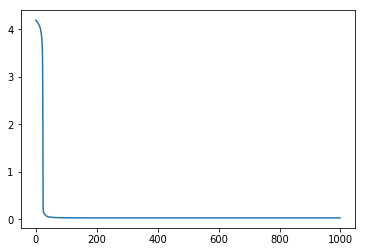

In [18]:
plt.plot(runningCost)

Based on the above it seems like the learning rates may be too low for this application but for now it is good for proof of concept that it is working.

# Checking to see accuracy of the model now that it is trained

In [19]:
print('Prediction Before Training')
predictions = np.array([])
for image_index in range(len(image_matrix)):
    
    # Get first input image
    current_image  = image_matrix[image_index] # 4x4 image
    
    # Recall output size of conv:
    # This can be found in Lecture 5 of the Standford notes
    # (ImageSize-FilterSize)/stride + 1    
    
    # Layer 1 conv + activation with zero padding
    l1 = convolve2d(current_image,w1,mode='valid') # 3x3 image b/c of the equation
    l1A = tanh(l1) # 3x3 image
    
    # Layer 2 conv + activation
    l2 = convolve2d(l1A,w2,mode='valid') # 2x2 image b/c of the equation
    l2A = arctan(l2)

    l3IN = np.expand_dims(l2A.ravel(),0) # 2x2 image stretched out is a 1x4 matrix

    l3 = l3IN.dot(w3) # by performing the dot product we essentially have the sum of all log errors for this particular image
    l3A = arctan(l3) # cost function (we can use log likelihood or just simply crosscorrelation)

    predictions = np.append(predictions,l3A)
print('---Groud Truth----')
print(image_label.T)
print('--Prediction-----')
print(predictions.T)
print('--Prediction Rounded-----')
print(np.round(predictions).T)
print("\n")

Prediction Before Training
---Groud Truth----
[[-1.42889927 -0.78539816  0.          1.46013911]]
--Prediction-----
[-1.2319709  -1.22598496 -0.00938882  1.23094729]
--Prediction Rounded-----
[-1. -1.  0.  1.]




This looks pretty good.  Let us improve these by applying what I've learned in the ANN case for updating the gradients and also initializing the weights.

# Model Improvements

## Hyper-parameters

In [20]:
num_epoch = 1000
learning_rate = 0.1
total_error = 0

In [21]:
w1 = np.random.randn(2,2)*np.sqrt(2/2)
w2 = np.random.randn(2,2)*np.sqrt(2/2)
w3 = np.random.randn(4,1)*np.sqrt(4/2)

In [22]:
mu = 0.9
v1 = 0
v2 = 0
v3 = 0

## Training

In [23]:
runningCost = []
for iter in range(num_epoch):
    
    for current_image_index in range(len(image_matrix)):
    
        # ---------------------------- Forward Propagations ----------------------------
        # get image and label
        current_image = image_matrix[current_image_index]
        current_image_label = image_label[current_image_index]

        # first layer conv + activation w/zero padding
        l1 = convolve2d(current_image,w1,mode='valid')
        l1A = tanh(l1)

        # second layer conv + activation w/zero padding
        l2 = convolve2d(l1A,w2,mode='valid')
        l2A = arctan(l2)

        # third layer - fully connected layer
        # stretching the image matrix to a vector 
        l3IN = np.expand_dims(l2A.ravel(),0)
        # performing summation and activation function
        l3 = l3IN.dot(w3)
        l3A = arctan(l3)

        # cost function generation. This is the sum of squared errors
        cost = np.square(l3A - current_image_label).sum() * 0.5
        total_error += cost
        
        # ---------------------------- Back Propagations ----------------------------
        # ---------- Calculations for dL/dw3 ----------
        # because this is simply the fully connected layer this is very similar to the vanilla back propagation
        # derivative of the cost function
        grad_3_part_1 = l3A - current_image_label
        # derivative of the activation function of the third layer
        grad_3_part_2 = d_arctan(l3)
        # the value comming into layer 3
        grad_3_part_3 =l3IN
        # vanilla way of getting dw3
        grad_3 =  grad_3_part_3.T.dot( grad_3_part_1 * grad_3_part_2)
        
        # ---------- Calculations for dL/dw2 ----------
        # the matrix going up stream
        grad_2_part_IN = np.reshape((grad_3_part_1 * grad_3_part_2).dot(w3.T),(2,2))
        grad_2_part_1 = grad_2_part_IN
        # derivative of the activation function of the second layer
        grad_2_part_2 = d_arctan(l2)
        # derivative of the linear function which is the downstream values or just the output of layer 1
        grad_2_part_3 = l1A
        # Notice here that there are two rotations of 90 degrees ... on for the horizontal and one for the vertical
        grad_2=  np.rot90( convolve2d(grad_2_part_3,np.rot90(grad_2_part_1 * grad_2_part_2,2),mode='valid')     ,2)
        
        # ---------- Calculations for dL/dw1 ----------
        # Note the padding is needed to retain the dimentions
        grad_1_part_IN_pad_weight = np.pad(w2,1,mode='constant')
        grad_1_part_IN = np.rot90(grad_2_part_1 * grad_2_part_2,2)
        # the derivative of the first conv layer note the rotation
        grad_1_part_1 = convolve2d(grad_1_part_IN_pad_weight,grad_1_part_IN,mode='valid')
        # the derivative of the activation function in this layer
        grad_1_part_2 = d_tanh(l1)
        # the linear derivate of this layer
        grad_1_part_3 = current_image
        # update by the double rotation again
        grad_1 =  np.rot90( convolve2d(grad_1_part_3,np.rot90(grad_1_part_1 * grad_1_part_2,2),mode='valid')     ,2)
        
        # ---------------------------- Update Weights ----------------------------
        # This is the vanilla way of updating the matrix
        # update w1 using momentum
        v1 = mu * v1 - learning_rate * grad_1
        w1 += v1
        
        # update w2 using momentum
        v2 = mu * v2 - learning_rate * grad_2
        w2 += v2
        
        # update w3 using momentum
        v3 = mu * v3 - learning_rate * grad_3
        w3 += v3
    print('Current iter:  ', iter, ' current cost: ', cost)
    runningCost.append(cost)
    total_error = 0

('Current iter:  ', 0, ' current cost: ', 0.986857648907661)
('Current iter:  ', 1, ' current cost: ', 0.008148344970708953)
('Current iter:  ', 2, ' current cost: ', 0.011295572958967002)
('Current iter:  ', 3, ' current cost: ', 0.033554137086483124)
('Current iter:  ', 4, ' current cost: ', 0.11865550539766087)
('Current iter:  ', 5, ' current cost: ', 0.02504546374713306)
('Current iter:  ', 6, ' current cost: ', 0.018918469167684703)
('Current iter:  ', 7, ' current cost: ', 0.01291360395769691)
('Current iter:  ', 8, ' current cost: ', 0.009482622063513245)
('Current iter:  ', 9, ' current cost: ', 0.008652309545559636)
('Current iter:  ', 10, ' current cost: ', 0.005373580725056791)
('Current iter:  ', 11, ' current cost: ', 0.003483372678264812)
('Current iter:  ', 12, ' current cost: ', 0.00345528865313943)
('Current iter:  ', 13, ' current cost: ', 0.004971191286715759)
('Current iter:  ', 14, ' current cost: ', 0.008057151025756354)
('Current iter:  ', 15, ' current cost: ',

('Current iter:  ', 167, ' current cost: ', 0.003379922409038307)
('Current iter:  ', 168, ' current cost: ', 0.0033286781869528103)
('Current iter:  ', 169, ' current cost: ', 0.003278874683101345)
('Current iter:  ', 170, ' current cost: ', 0.003230439790952477)
('Current iter:  ', 171, ' current cost: ', 0.003183326113009805)
('Current iter:  ', 172, ' current cost: ', 0.0031374806360751385)
('Current iter:  ', 173, ' current cost: ', 0.0030928487167704985)
('Current iter:  ', 174, ' current cost: ', 0.003049387625194953)
('Current iter:  ', 175, ' current cost: ', 0.003007048734062808)
('Current iter:  ', 176, ' current cost: ', 0.002965788771908363)
('Current iter:  ', 177, ' current cost: ', 0.0029255690085813117)
('Current iter:  ', 178, ' current cost: ', 0.002886348765591053)
('Current iter:  ', 179, ' current cost: ', 0.0028480925214957294)
('Current iter:  ', 180, ' current cost: ', 0.0028107655395923367)
('Current iter:  ', 181, ' current cost: ', 0.0027743335944414036)
('C

('Current iter:  ', 365, ' current cost: ', 0.0007350482181450788)
('Current iter:  ', 366, ' current cost: ', 0.0007317882537221772)
('Current iter:  ', 367, ' current cost: ', 0.0007285543940276828)
('Current iter:  ', 368, ' current cost: ', 0.0007253463452524116)
('Current iter:  ', 369, ' current cost: ', 0.0007221638179083309)
('Current iter:  ', 370, ' current cost: ', 0.0007190065267497728)
('Current iter:  ', 371, ' current cost: ', 0.0007158741906963358)
('Current iter:  ', 372, ' current cost: ', 0.0007127665327574924)
('Current iter:  ', 373, ' current cost: ', 0.0007096832799588312)
('Current iter:  ', 374, ' current cost: ', 0.0007066241632698528)
('Current iter:  ', 375, ' current cost: ', 0.0007035889175333637)
('Current iter:  ', 376, ' current cost: ', 0.0007005772813963339)
('Current iter:  ', 377, ' current cost: ', 0.0006975889972422453)
('Current iter:  ', 378, ' current cost: ', 0.0006946238111249235)
('Current iter:  ', 379, ' current cost: ', 0.0006916814727036

('Current iter:  ', 487, ' current cost: ', 0.00046977085914982523)
('Current iter:  ', 488, ' current cost: ', 0.0004683480518416927)
('Current iter:  ', 489, ' current cost: ', 0.0004669334842449984)
('Current iter:  ', 490, ' current cost: ', 0.0004655270909247457)
('Current iter:  ', 491, ' current cost: ', 0.00046412880711827793)
('Current iter:  ', 492, ' current cost: ', 0.000462738568726757)
('Current iter:  ', 493, ' current cost: ', 0.00046135631230680786)
('Current iter:  ', 494, ' current cost: ', 0.0004599819750622067)
('Current iter:  ', 495, ' current cost: ', 0.0004586154948357607)
('Current iter:  ', 496, ' current cost: ', 0.000457256810101296)
('Current iter:  ', 497, ' current cost: ', 0.00045590585995571926)
('Current iter:  ', 498, ' current cost: ', 0.0004545625841112793)
('Current iter:  ', 499, ' current cost: ', 0.0004532269228878661)
('Current iter:  ', 500, ' current cost: ', 0.000451898817205467)
('Current iter:  ', 501, ' current cost: ', 0.000450578208576

('Current iter:  ', 663, ' current cost: ', 0.00030586596390036735)
('Current iter:  ', 664, ' current cost: ', 0.0003052706078240815)
('Current iter:  ', 665, ' current cost: ', 0.00030467779005040194)
('Current iter:  ', 666, ' current cost: ', 0.0003040874962163194)
('Current iter:  ', 667, ' current cost: ', 0.00030349971206274394)
('Current iter:  ', 668, ' current cost: ', 0.00030291442343362984)
('Current iter:  ', 669, ' current cost: ', 0.0003023316162750301)
('Current iter:  ', 670, ' current cost: ', 0.00030175127663419483)
('Current iter:  ', 671, ' current cost: ', 0.0003011733906586973)
('Current iter:  ', 672, ' current cost: ', 0.00030059794459553314)
('Current iter:  ', 673, ' current cost: ', 0.0003000249247902579)
('Current iter:  ', 674, ' current cost: ', 0.000299454317686103)
('Current iter:  ', 675, ' current cost: ', 0.00029888610982313507)
('Current iter:  ', 676, ' current cost: ', 0.00029832028783740477)
('Current iter:  ', 677, ' current cost: ', 0.000297756

('Current iter:  ', 840, ' current cost: ', 0.00023011453704838963)
('Current iter:  ', 841, ' current cost: ', 0.00022981255313159115)
('Current iter:  ', 842, ' current cost: ', 0.00022951161474059925)
('Current iter:  ', 843, ' current cost: ', 0.00022921171723278735)
('Current iter:  ', 844, ' current cost: ', 0.00022891285599161137)
('Current iter:  ', 845, ' current cost: ', 0.00022861502642643484)
('Current iter:  ', 846, ' current cost: ', 0.00022831822397234057)
('Current iter:  ', 847, ' current cost: ', 0.0002280224440899572)
('Current iter:  ', 848, ' current cost: ', 0.00022772768226529653)
('Current iter:  ', 849, ' current cost: ', 0.00022743393400955823)
('Current iter:  ', 850, ' current cost: ', 0.00022714119485897798)
('Current iter:  ', 851, ' current cost: ', 0.00022684946037465305)
('Current iter:  ', 852, ' current cost: ', 0.00022655872614235888)
('Current iter:  ', 853, ' current cost: ', 0.00022626898777240945)
('Current iter:  ', 854, ' current cost: ', 0.000

('Current iter:  ', 988, ' current cost: ', 0.00019475405772659228)
('Current iter:  ', 989, ' current cost: ', 0.0001945673382720236)
('Current iter:  ', 990, ' current cost: ', 0.00019438118810936018)
('Current iter:  ', 991, ' current cost: ', 0.0001941956050794479)
('Current iter:  ', 992, ' current cost: ', 0.00019401058703337056)
('Current iter:  ', 993, ' current cost: ', 0.0001938261318324139)
('Current iter:  ', 994, ' current cost: ', 0.00019364223734798632)
('Current iter:  ', 995, ' current cost: ', 0.00019345890146156577)
('Current iter:  ', 996, ' current cost: ', 0.00019327612206464283)
('Current iter:  ', 997, ' current cost: ', 0.00019309389705866815)
('Current iter:  ', 998, ' current cost: ', 0.00019291222435497847)
('Current iter:  ', 999, ' current cost: ', 0.00019273110187477066)


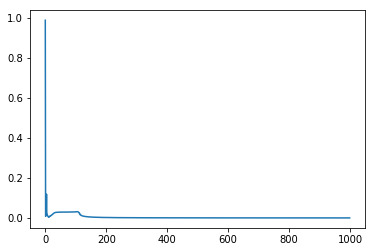

In [24]:
plt.plot(runningCost)

Wow just by looking at the cost it seems that it identified various saddle and local minima until stabilizing to an appropriate minima

## Testing

In [25]:
print('Prediction Before Training')
predictions = np.array([])
for image_index in range(len(image_matrix)):
    
    # Get first input image
    current_image  = image_matrix[image_index] # 4x4 image
    
    # Recall output size of conv:
    # This can be found in Lecture 5 of the Standford notes
    # (ImageSize-FilterSize)/stride + 1    
    
    # Layer 1 conv + activation with zero padding
    l1 = convolve2d(current_image,w1,mode='valid') # 3x3 image b/c of the equation
    l1A = tanh(l1) # 3x3 image
    
    # Layer 2 conv + activation
    l2 = convolve2d(l1A,w2,mode='valid') # 2x2 image b/c of the equation
    l2A = arctan(l2)

    l3IN = np.expand_dims(l2A.ravel(),0) # 2x2 image stretched out is a 1x4 matrix

    l3 = l3IN.dot(w3) # by performing the dot product we essentially have the sum of all log errors for this particular image
    l3A = arctan(l3) # cost function (we can use log likelihood or just simply crosscorrelation)

    predictions = np.append(predictions,l3A)
print('---Groud Truth----')
print(image_label.T)
print('--Prediction-----')
print(predictions.T)
print('--Prediction Rounded-----')
print(np.round(predictions).T)
print("\n")

Prediction Before Training
---Groud Truth----
[[-1.42889927 -0.78539816  0.          1.46013911]]
--Prediction-----
[-1.44054298e+00 -7.85625573e-01  1.25313011e-05  1.44051181e+00]
--Prediction Rounded-----
[-1. -1.  0.  1.]




In [26]:
# Based on the above results
prevPredictions = np.array([-1.44102050, -0.785358646, -0.0000404112065, 1.44102039])
improvedPrediction = np.array([-1.44195325, -0.785544245,  0.0000108790442, 1.44191998])

In [27]:
np.sum(np.abs(improvedPrediction - prevPredictions)**2)

1.7163624092178218e-06

Although this is a negligible difference, if we look at the lost of training and loss function the second one seems to be more generalized and the training converges to a better minima. 